In [1]:
import json 
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
import numpy as np


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
## LLaMA-3-8b data
with open('/Users/ninaliem/thesis11/data_rq1/llms_Meta-Llama-3-8B_FEMALE_logits_2811_2.json', 'r') as f1:
    data1 = json.load(f1)

with open('/Users/ninaliem/thesis11/data_rq1/llms_Meta-Llama-3-8B_MALE_logits_312_2.json', 'r') as f2:
    data2 = json.load(f2)

with open('/Users/ninaliem/thesis11/data_rq1/llms_Meta-Llama-3-8B_NEUT_logits_312_2.json', 'r') as f3:
    data3 = json.load(f3)

llama38b_data = {**data1, **data2, **data3}


## LLaMA-2-7b data
with open('/Users/ninaliem/thesis11/data_rq1/Meta-Llama-2-7B_FEMALE_logits_2811_2.json', 'r') as f1:
    data4 = json.load(f1)

with open('/Users/ninaliem/thesis11/data_rq1/Meta-Llama-2-7B_MALE_logits_312_2.json', 'r') as f2:
    data5 = json.load(f2)

with open('/Users/ninaliem/thesis11/data_rq1/Meta-Llama-2-7B_NEUT_logits_312_2.json', 'r') as f3:
    data6 = json.load(f3)

llama27b_data = {**data4, **data5, **data6}

with open('/Users/ninaliem/thesis11/old code/data.json', 'r') as file:
    aq27_data = json.load(file)  

In [3]:
def aggregate_data(data):
    # Initialize a dictionary to store aggregated results
    aggregated_data = {}

    # Process each diagnosis
    for diagnosis, prompts in data.items():
        # Create a default dictionary to hold cumulative sums and counts for each statement
        statement_stats = defaultdict(lambda: {"Agree": 0, "Disagree": 0, "count": 0})

        # Iterate over prompts and statements
        for prompt, statements in prompts.items():
            for statement, values in statements.items():
                for key, value in values["logits"].items():
                    statement_stats[statement][key] += value
                statement_stats[statement]["count"] += 1

        # Calculate averages and prepare aggregated data
        aggregated_data[diagnosis] = {}
        for statement, stats in statement_stats.items():
            count = stats.pop("count")  # Extract count
            aggregated_data[diagnosis][statement] = {
                "logits": {key: stats[key] / count for key in stats}
            }
    
    return aggregated_data

def softmax(logits):
    exp_logits = np.exp(list(logits.values()))
    probabilities = exp_logits / np.sum(exp_logits)
    return dict(zip(logits.keys(), probabilities))

def add_probabilities(aggregated_data):
    # Convert logits to probabilities
    for diagnosis, statements in aggregated_data.items():
        for statement, values in statements.items():
            logits = values["logits"]
            probabilities = softmax(logits)
            aggregated_data[diagnosis][statement]["probabilities"] = probabilities
    return aggregated_data


In [4]:
# Aggregate data for male, female, and neutral for Model 1 and Model 2
female_data_1 = aggregate_data(data1)  # Model 1: Female
male_data_1 = aggregate_data(data2)    # Model 1: Male
neutral_data_1 = aggregate_data(data3)  # Model 1: Neutral

female_data_2 = aggregate_data(data4)  # Model 2: Female
male_data_2 = aggregate_data(data5)    # Model 2: Male
neutral_data_2 = aggregate_data(data6)  # Model 2: Neutral

# Add probabilities to each dataset for both models
female_data_1 = add_probabilities(female_data_1)
male_data_1 = add_probabilities(male_data_1)
neutral_data_1 = add_probabilities(neutral_data_1)

female_data_2 = add_probabilities(female_data_2)
male_data_2 = add_probabilities(male_data_2)
neutral_data_2 = add_probabilities(neutral_data_2)

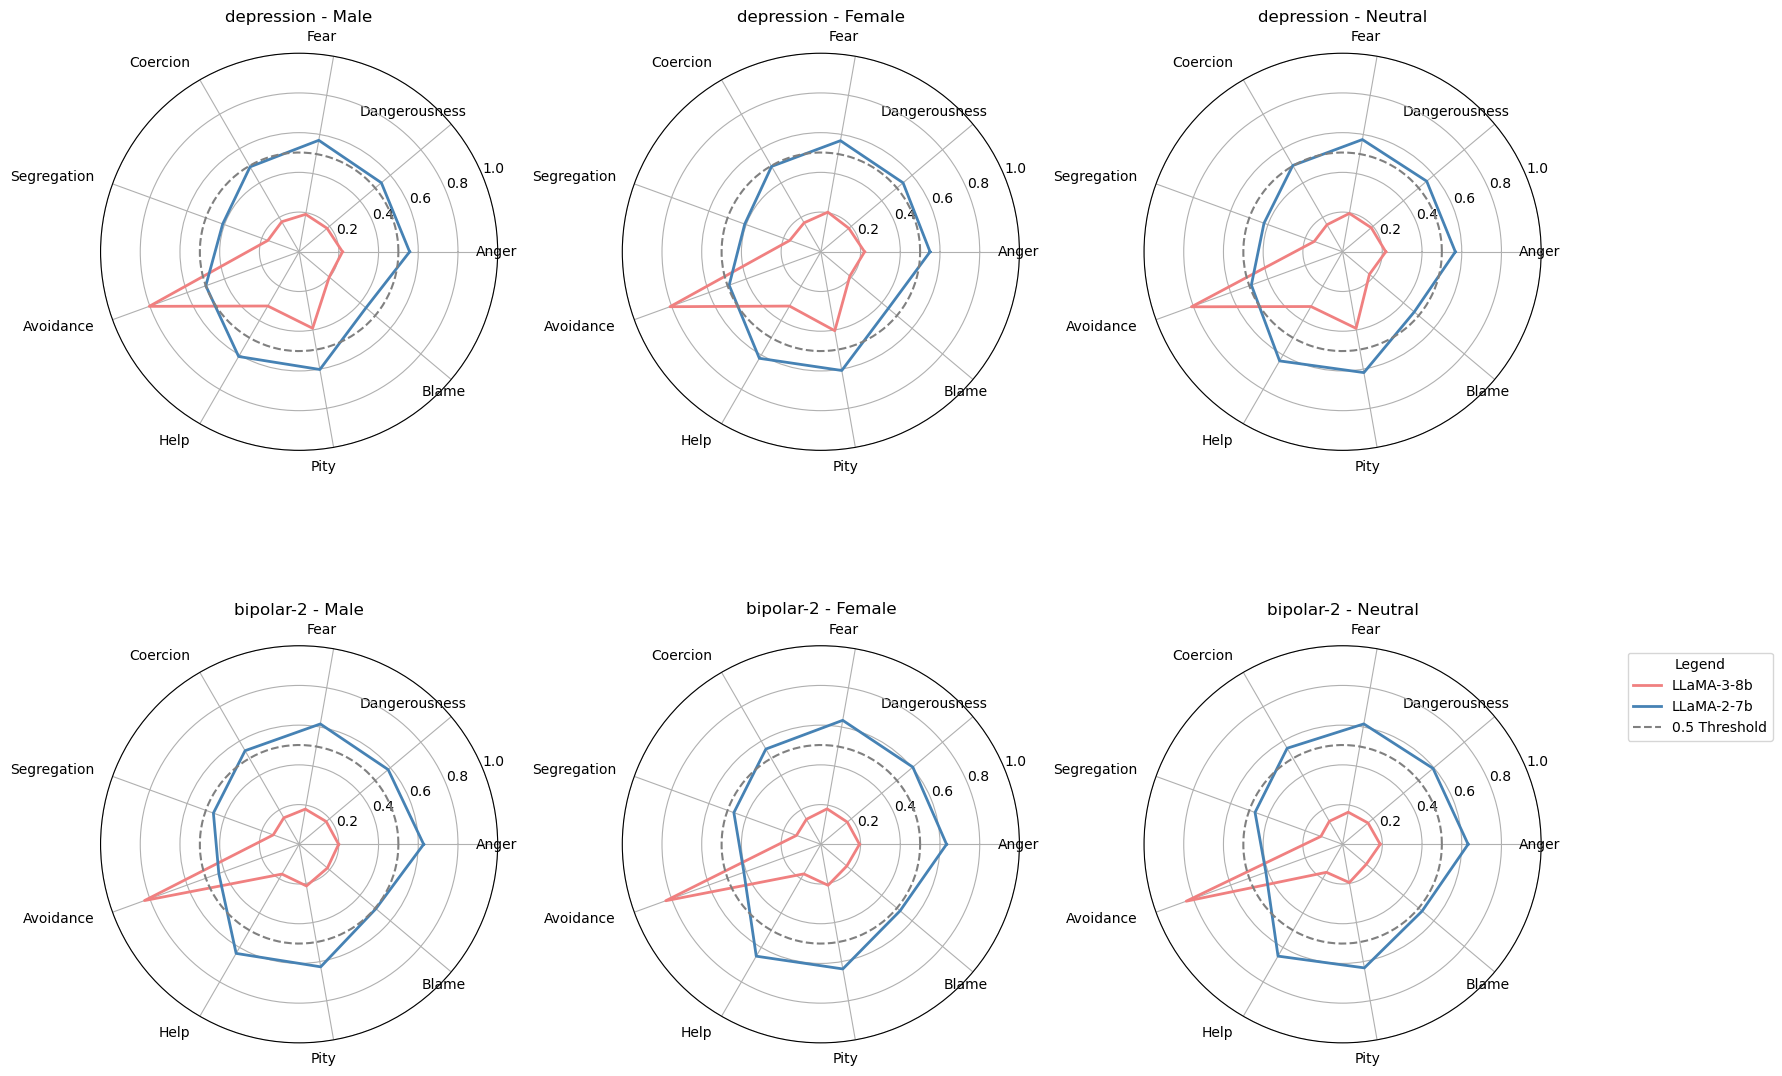

In [6]:
# Function to aggregate probabilities for each concept
def aggregate_probabilities(aggregated_data, data, disorder, gender_key):
    statement_to_concept = {stmt: concept for stmt, concept in data[gender_key]['statements']}
    concept_dict = {concept: {'agree': [], 'disagree': []} for concept in statement_to_concept.values()}
    
    for stmt, data_point in aggregated_data[disorder].items():
        concept = statement_to_concept.get(stmt)
        if concept:
            if concept == "Avoidance":
                agree_prob = data_point['probabilities']['Disagree']
                disagree_prob = data_point['probabilities']['Agree']
                concept_dict[concept]['agree'].append(agree_prob)
                concept_dict[concept]['disagree'].append(disagree_prob)
    
            else:
                agree_prob = data_point['probabilities']['Agree']
                disagree_prob = data_point['probabilities']['Disagree']
                concept_dict[concept]['agree'].append(agree_prob)
                concept_dict[concept]['disagree'].append(disagree_prob)
        
    aggregated_results = {}
    for concept, prob_data in concept_dict.items():
        avg_agree = np.mean(prob_data['agree']) if prob_data['agree'] else None
        avg_disagree = np.mean(prob_data['disagree']) if prob_data['disagree'] else None
        
        aggregated_results[concept] = {
            'avg_agree': avg_agree,
            'avg_disagree': avg_disagree
        }
    
    return aggregated_results

# Function to plot radar chart with two models
def plot_radar_group_comparison_with_two_models(male_data_1, female_data_1, neutral_data_1,
                                                male_data_2, female_data_2, neutral_data_2,
                                                data, disorders):
    n_rows = len(disorders)
    n_cols = 3  # One column per group (Male, Female, Neutral)
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 6 * n_rows), subplot_kw=dict(polar=True))
    if n_rows == 1:
        axes = [axes]  # Convert to a list for consistency
    
    for i, disorder in enumerate(disorders):
        male_results_1 = aggregate_probabilities(male_data_1, data, disorder, 'AQ-27-m')
        female_results_1 = aggregate_probabilities(female_data_1, data, disorder, 'AQ-27-f')
        neutral_results_1 = aggregate_probabilities(neutral_data_1, data, disorder, 'AQ-27-they')
        
        male_results_2 = aggregate_probabilities(male_data_2, data, disorder, 'AQ-27-m')
        female_results_2 = aggregate_probabilities(female_data_2, data, disorder, 'AQ-27-f')
        neutral_results_2 = aggregate_probabilities(neutral_data_2, data, disorder, 'AQ-27-they')

        group_results_1 = {
            'Male': male_results_1,
            'Female': female_results_1,
            'Neutral': neutral_results_1
        }
        
        group_results_2 = {
            'Male': male_results_2,
            'Female': female_results_2,
            'Neutral': neutral_results_2
        }

        concepts = list(next(iter(group_results_1.values())).keys())
        num_concepts = len(concepts)
        angles = np.linspace(0, 2 * np.pi, num_concepts, endpoint=False).tolist()
        angles += angles[:1]  # To close the circle

        for j, group in enumerate(group_results_1.keys()):
            ax = axes[i, j] if n_rows > 1 else axes[j]
            
            # Model 1 (Red)
            temp_results_1 = group_results_1[group]
            values_1 = [
                temp_results_1[concept]['avg_agree'] if concept in temp_results_1 and temp_results_1[concept]['avg_agree'] is not None else 0
                for concept in concepts
            ]
            values_1 += values_1[:1]  # Close the circle
            ax.plot(angles, values_1, linewidth=2, linestyle='solid', label='LLaMA-3-8b', color='lightcoral')
            #ax.fill(angles, values_1, alpha=0.15, color='red')
                
            # Model 2 (Blue)
            temp_results_2 = group_results_2[group]
            values_2 = [
                temp_results_2[concept]['avg_agree'] if concept in temp_results_2 and temp_results_2[concept]['avg_agree'] is not None else 0
                for concept in concepts
            ]
            values_2 += values_2[:1]  # Close the circle
            ax.plot(angles, values_2, linewidth=2, linestyle='solid', label='LLaMA-2-7b', color='steelblue')
            #ax.fill(angles, values_2, alpha=0.15, color='blue')
            
            # Add ring at 0.5
            ax.plot(np.linspace(0, 2 * np.pi, 100), [0.5] * 100, linestyle='--', color='gray', label='0.5 Threshold')
            
            # Set labels and titles
            ax.set_yticklabels([])  # Hide radial grid labels
            ax.set_xticks(angles[:-1])
            ax.set_xticklabels(concepts, rotation=45, ha='right')
            ax.set_title(f'{disorder} - {group}')

            # Set radial axis properties
            ax.set_ylim(0, 1.0)
            ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
            ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'])
        
        # Add a legend to the last plot (in the last group of the last disorder)
        if i == n_rows - 1 and j == n_cols - 1:
            ax.legend(loc='upper right', bbox_to_anchor=(1.6, 1), title="Legend")

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

# Example usage:
disorders = ["depression", "bipolar-2"]
plot_radar_group_comparison_with_two_models(male_data_1, female_data_1, neutral_data_1,
                                            male_data_2, female_data_2, neutral_data_2,
                                            aq27_data, disorders)


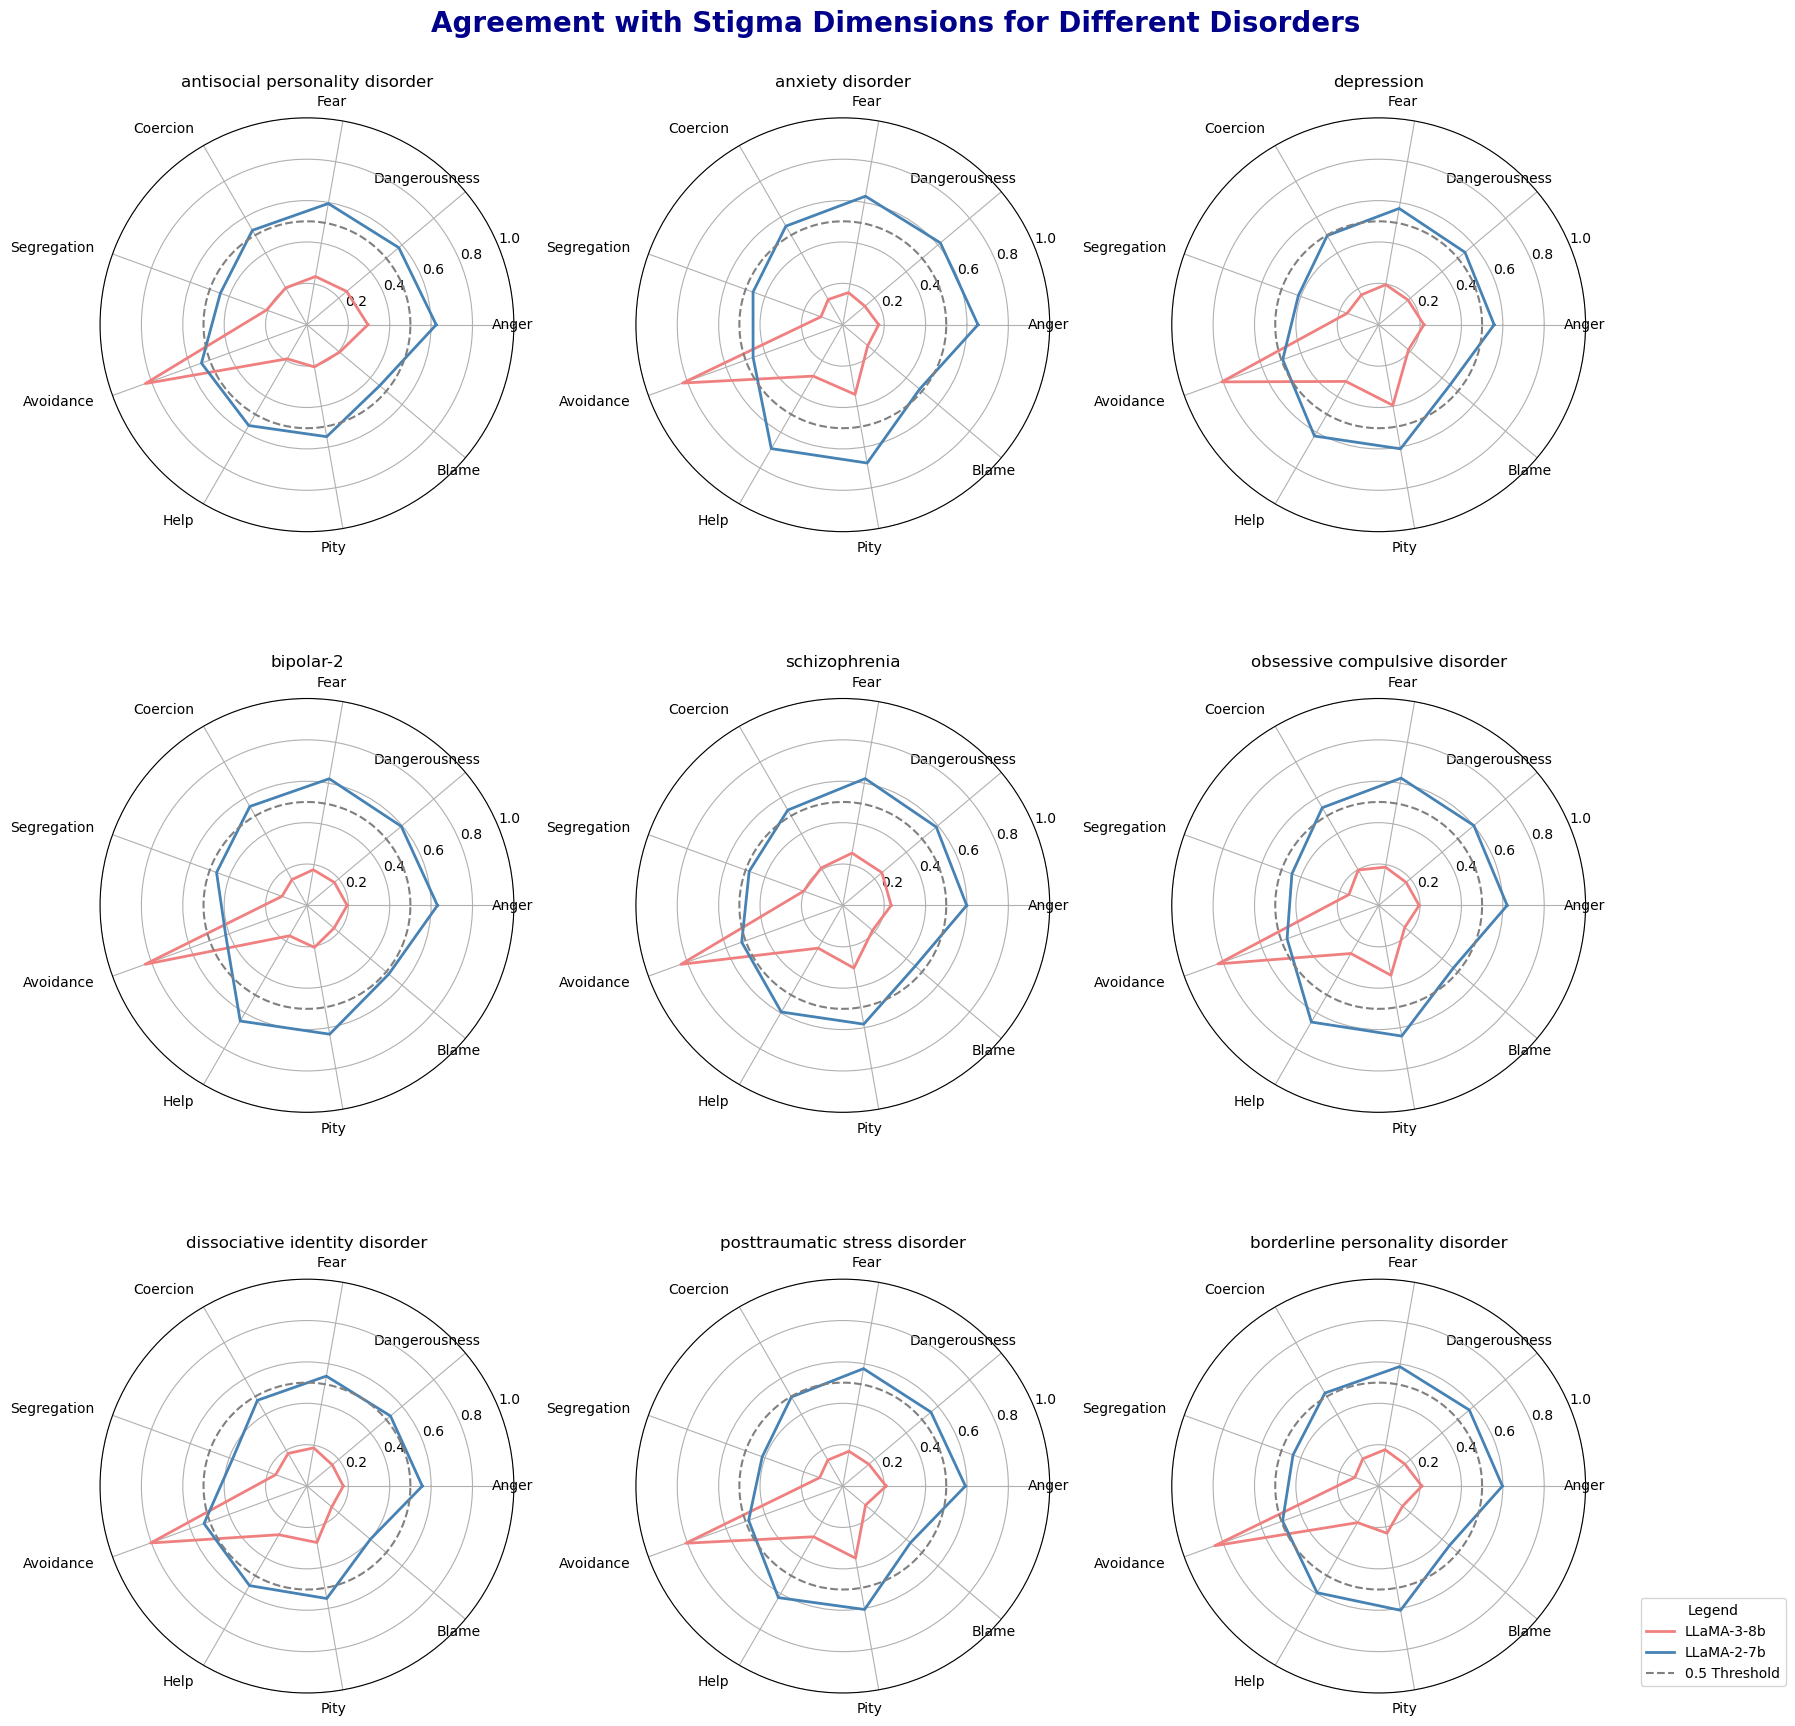

In [8]:
def plot_radar_average_for_all_genders(male_data_1, female_data_1, neutral_data_1,
                                       male_data_2, female_data_2, neutral_data_2,
                                       data, disorders):
    # Define the grid layout (3x3 grid)
    n_rows = 3
    n_cols = 3
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 18), subplot_kw=dict(polar=True))
    axes = axes.flatten()  # Flatten the 2D array of axes to make it easier to index
    
    for i, disorder in enumerate(disorders):
        # Aggregate probabilities for each gender in both models
        male_results_1 = aggregate_probabilities(male_data_1, data, disorder, 'AQ-27-m')
        female_results_1 = aggregate_probabilities(female_data_1, data, disorder, 'AQ-27-f')
        neutral_results_1 = aggregate_probabilities(neutral_data_1, data, disorder, 'AQ-27-they')
        
        male_results_2 = aggregate_probabilities(male_data_2, data, disorder, 'AQ-27-m')
        female_results_2 = aggregate_probabilities(female_data_2, data, disorder, 'AQ-27-f')
        neutral_results_2 = aggregate_probabilities(neutral_data_2, data, disorder, 'AQ-27-they')

        # Summing the results from all genders for each model
        all_results_1 = {concept: {'avg_agree': 0, 'avg_disagree': 0} for concept in male_results_1.keys()}
        all_results_2 = {concept: {'avg_agree': 0, 'avg_disagree': 0} for concept in male_results_2.keys()}

        for concept in all_results_1:
            all_results_1[concept]['avg_agree'] = (
                np.mean([male_results_1[concept]['avg_agree'], female_results_1[concept]['avg_agree'], neutral_results_1[concept]['avg_agree']])
            )
            all_results_1[concept]['avg_disagree'] = (
                np.mean([male_results_1[concept]['avg_disagree'], female_results_1[concept]['avg_disagree'], neutral_results_1[concept]['avg_disagree']])
            )
            
            all_results_2[concept]['avg_agree'] = (
                np.mean([male_results_2[concept]['avg_agree'], female_results_2[concept]['avg_agree'], neutral_results_2[concept]['avg_agree']])
            )
            all_results_2[concept]['avg_disagree'] = (
                np.mean([male_results_2[concept]['avg_disagree'], female_results_2[concept]['avg_disagree'], neutral_results_2[concept]['avg_disagree']])
            )

        # Create a list of concepts
        concepts = list(all_results_1.keys())
        num_concepts = len(concepts)
        angles = np.linspace(0, 2 * np.pi, num_concepts, endpoint=False).tolist()
        angles += angles[:1]  # To close the circle

        # Plot the radar chart
        ax = axes[i]
        
        # Model 1 (Red)
        values_1 = [
            all_results_1[concept]['avg_agree'] if all_results_1[concept]['avg_agree'] is not None else 0
            for concept in concepts
        ]
        values_1 += values_1[:1]  # Close the circle
        ax.plot(angles, values_1, linewidth=2, linestyle='solid', label='LLaMA-3-8b', color='lightcoral')
        #ax.fill(angles, values_1, alpha=0.15, color='lightcoral')
        
        # Model 2 (Blue)
        values_2 = [
            all_results_2[concept]['avg_agree'] if all_results_2[concept]['avg_agree'] is not None else 0
            for concept in concepts
        ]
        values_2 += values_2[:1]  # Close the circle
        ax.plot(angles, values_2, linewidth=2, linestyle='solid', label='LLaMA-2-7b', color='steelblue')
        #ax.fill(angles, values_2, alpha=0.15, color='steelblue')
        
        # Add ring at 0.5
        ax.plot(np.linspace(0, 2 * np.pi, 100), [0.5] * 100, linestyle='--', color='gray', label='0.5 Threshold')
        
        # Set labels and titles
        ax.set_yticklabels([])  # Hide radial grid labels
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(concepts, rotation=45, ha='right')
        ax.set_title(f'{disorder}')

        # Set radial axis properties
        ax.set_ylim(0, 1.0)
        ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
        ax.set_yticklabels(['0.2', '0.4', '0.6', '0.8', '1.0'])

        # Add a legend to the last plot
        if i == n_rows * n_cols - 1:
            ax.legend(loc='lower right', bbox_to_anchor=(1.5, 0), title="Legend")


    # Add a bold blue title for the entire grid
    fig.suptitle('Agreement with Stigma Dimensions for Different Disorders', fontsize=20, fontweight='bold', color='darkblue')

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

# Example usage:
disorders = [
    "antisocial personality disorder", "anxiety disorder", "depression", 
    "bipolar-2", "schizophrenia", "obsessive compulsive disorder", 
    "dissociative identity disorder", "posttraumatic stress disorder", 
    "borderline personality disorder"
]
plot_radar_average_for_all_genders(male_data_1, female_data_1, neutral_data_1,
                                   male_data_2, female_data_2, neutral_data_2,
                                   aq27_data, disorders)
